# Practicals in Seismology, winter semester 2024/25 
_____

### Week 11, 23 Jan. 2025
### Topics: AI in Seismology
### Responsible: Dr. Janis Heuel

-------

**In this week's practicals you will learn**

* Quick overview about SeisBench (Presentation)
* How to pick seismic phase onset using AI pickers
* Denoising data with SeisBench

-----
**Advanced excercise (e.g. for Master thesis etc.)**
* Training of new models for picking or denoising (denoisong not implemented yet)
* Create your own training datasets
* Comparing models trained on different datasets
* Building seismic catalogues usind phase picking followed by phase association algorithms\
  For more details: https://github.com/seisbench/seisbench

---
**To use this Jupyter notebook, load the ```seisml``` environment**

---

In [14]:
# Imports
import os
import glob
import obspy
import seisbench

import numpy as np
import matplotlib.pyplot as plt
import seisbench.models as sbm

from obspy import UTCDateTime
from obspy.clients.fdsn import Client


def phase_color(phase: str) -> str:
    if phase == "P":
        return "blue"
    elif phase == "S":
        return "red"


def plot_sb_pick(pick, ax, stream):
    peak_time = pick.peak_time
    p_color = phase_color(phase=pick.phase)
    # Convert peak time to samples
    peak_samp = int((peak_time - stream[0].stats.starttime) * stream[0].stats.sampling_rate)
    ax.axvline(peak_samp, 
               linewidth=2, 
               color=p_color, 
               zorder=-1,
               label=pick.phase)

---------------
### Task 1:
Read data from one of the provided events, i.e. event01 or event02 and have a look at the seismograms

---
### Example how to pick phases using SeisBench's implementation of PhaseNet

In [ ]:
# Select one stream from an event
stream = obspy.read("./earthquake_data/event02/CH.FIESA..HH.2023.152")
# stream.plot();

# Pick phases with the loaded PhaseNet model
picks = pn_model.classify(stream,
                          P_threshold=0.2,
                          S_threshold=0.2)
print(picks)

# Determine output probability and plot Z component of stream, probability of PhaseNet and picks
pn_probability = pn_model.annotate(stream)

plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(stream.select(component="Z")[0].data, color="k")

# Plot picks as vertical lines
for pick in picks.picks:
    peak_time = pick.peak_time
    # Convert peak time to samples
    peak_samp = int((peak_time - stream[0].stats.starttime) * stream[0].stats.sampling_rate)
    plt.axvline(peak_samp, linewidth=2)

plt.subplot(212)
for prob in pn_probability:
    plt.plot(prob, label=prob.stats.channel.split("|")[0])
plt.legend()

----
### Task 2: 
Go through all earthquake waveforms and compute the phase onsets with the previously loaded PhaseNet model (if you like, you can also select a different model. For this replace "original" by one the following strings: ethz, instance, scedc, stead, geofon, neic
* Find the clostest station with respect to the earthquake source from your picked phases.\
  *Hint:* Ignore stations where only a single phase (i.e. either P or S but not both) are deteced)\
  *Hint:* Phase typy can be found by using ```pick.phase```
* Create a plot of the waveform with the picks of the nearest and furthest station.
* What are the difference regarding the quality of the picks of the the other models?
* What happens if you choose different values for P- and S-threshold when classifying streams with SeisBench?

/home/janis/miniconda3/envs/seisbench/lib/python3.11/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(f"{

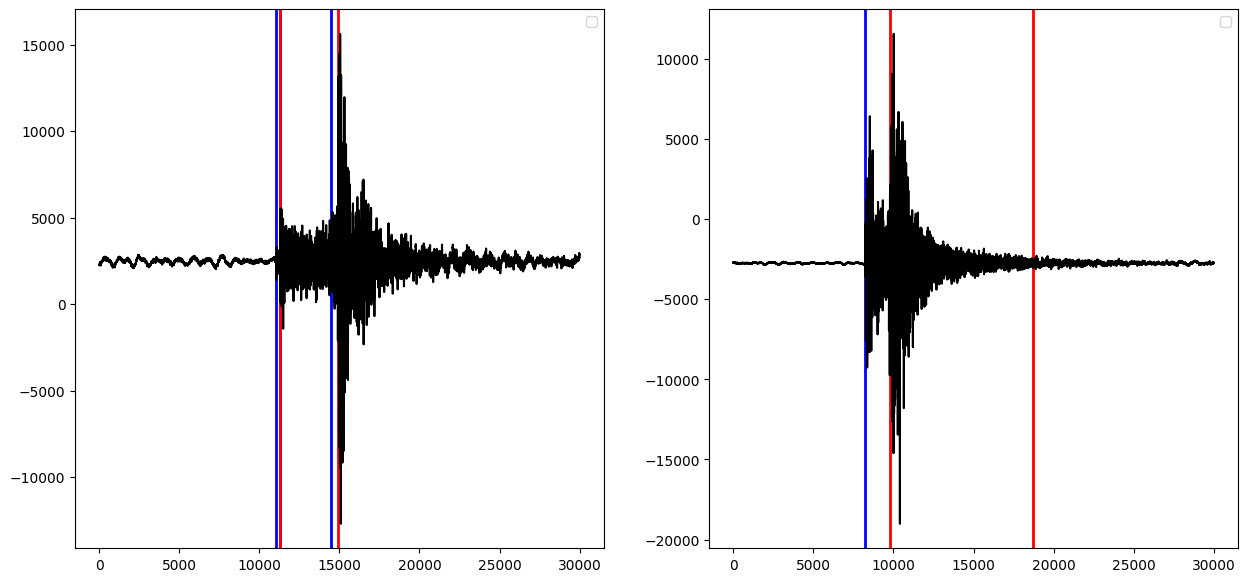

In [23]:
# Load a pretrained model
pn_model = sbm.PhaseNet.from_pretrained("original")


------
### How to denoise data 

/home/janis/miniconda3/envs/seisbench/lib/python3.11/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(f"{

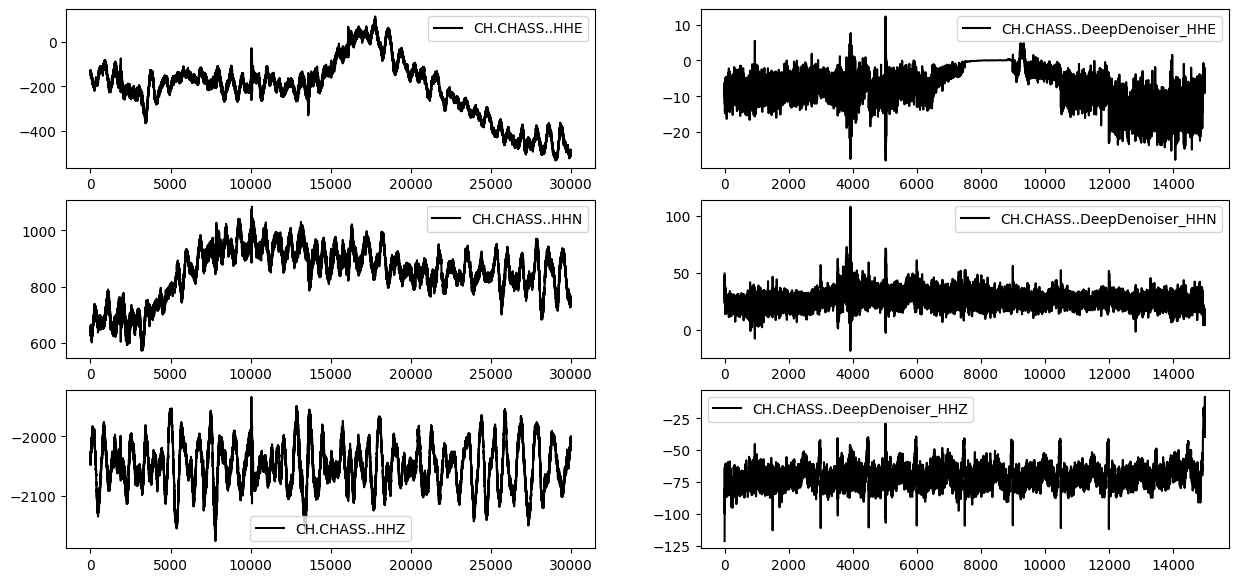

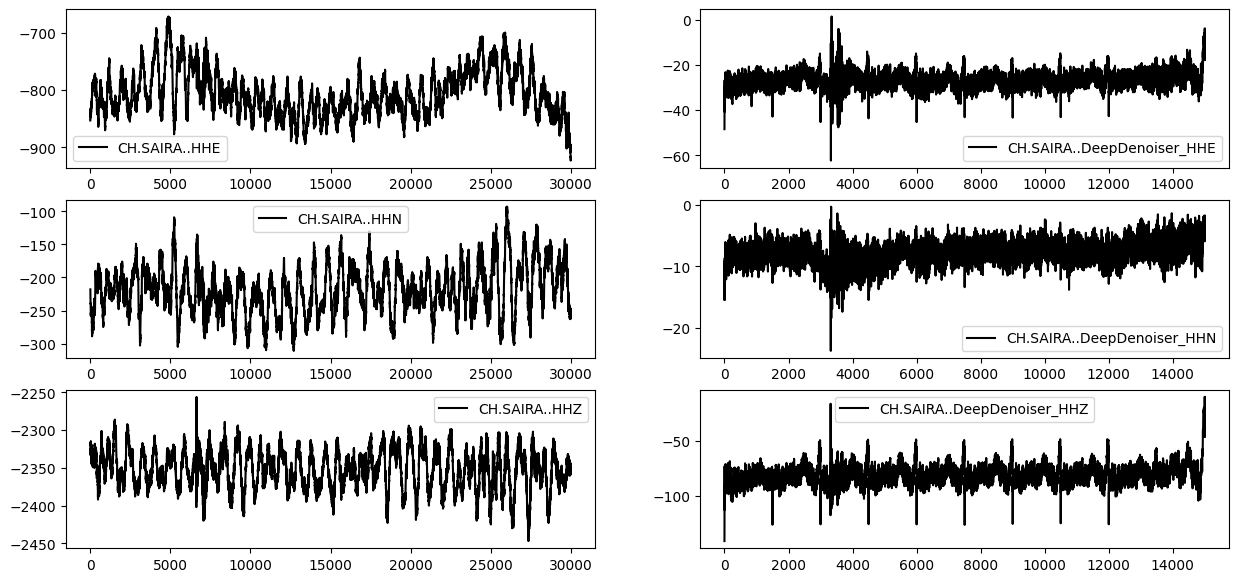

In [29]:
streams_noisy = glob.glob("./earthquake_data/noisy_event01/*")
model_denoise = sbm.DeepDenoiser.from_pretrained("original")    # Load pretrained denoising model
for file in streams_noisy:
    stream = obspy.read(file)
    stream_cp = stream.copy()

    # Denoise stream
    stream_denoised = model_denoise.annotate(stream)

    # Plot noisy and denoised stream
    fig = plt.figure(figsize=(15, 7))

    # Plot noisy traces
    for idx, trace in zip([1, 3, 5], stream):
        ax = fig.add_subplot(3, 2, idx)
        label = f"{trace.stats.network}.{trace.stats.station}..{trace.stats.channel}"
        ax.plot(trace.data, color="k", label=label)
        ax.legend()

    # Plot denoised traces
    for idx, trace in zip([2, 4, 6], stream_denoised):
        ax = fig.add_subplot(3, 2, idx)
        label = f"{trace.stats.network}.{trace.stats.station}..{trace.stats.channel}"
        ax.plot(trace.data, color="k", label=label)
        ax.legend()